In [51]:
!python --version

Python 3.8.20


In [52]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [53]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [54]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    tf.config.set_visible_devices(physical_devices[0], 'GPU')
    print("Using GPU:", physical_devices[0])
else:
    print("No GPU found, using CPU.")

Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [56]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [57]:
dataset_path = "/Users/seojeongmin/Desktop/study/Human_Activity_Recognition/dataset/human+activity+recognition+using+smartphones/UCI HAR Dataset/"
train_path = "train/"
test_path = "test/"

In [58]:
input_signal_types = [
    "body_acc_x_", "body_acc_y_", "body_acc_z_",
    "body_gyro_x_", "body_gyro_y_", "body_gyro_z_",
    "total_acc_x_", "total_acc_y_", "total_acc_z_"
]

labels = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING"]

In [ ]:
def load_x(x_signals_paths):
    x_signals = []
    for signal_type_path in x_signals_paths:
        with open(signal_type_path, 'r') as file:
            x_signals.append(
                np.array([
                    [float(val) for val in row.strip().split()] for row in file
                ])
            )
    return np.transpose(np.array(x_signals), (1, 2, 0))

def load_y(y_path):
    with open(y_path, 'r') as file:
        y_ = np.array([int(row.strip()) for row in file])
    return y_ - 1

In [ ]:
x_train_signals_paths = [
    dataset_path + train_path + "Inertial Signals/" + signal + "train.txt" for signal in input_signal_types
]
x_test_signals_paths = [
    dataset_path + test_path + "Inertial Signals/" + signal + "test.txt" for signal in input_signal_types
]

x_train = load_x(x_train_signals_paths)
x_test = load_x(x_test_signals_paths)

y_train_path = dataset_path + train_path + "y_train.txt"
y_test_path = dataset_path + test_path + "y_test.txt"

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

In [ ]:
print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")  
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")  

x_train shape: (7352, 128, 9)
x_test shape: (2947, 128, 9)
y_train shape: (7352,)
y_test shape: (2947,)


In [ ]:
def preprocess_data(x, y, n_classes):
    x = (x - np.mean(x)) / np.std(x) 
    y_onehot = tf.keras.utils.to_categorical(y, num_classes=n_classes)
    return x, y_onehot

In [ ]:
n_classes = 6
x_train, y_train_onehot = preprocess_data(x_train, y_train, n_classes)
x_test, y_test_onehot = preprocess_data(x_test, y_test, n_classes)

In [ ]:
training_data_count = len(x_train)  
test_data_count = len(x_test) 
n_steps = len(x_train[0]) 
n_input = len(x_train[0][0])

print(f"Training Data Count: {training_data_count}")
print(f"Test Data Count: {test_data_count}")
print(f"Steps per Series: {n_steps}")
print(f"Input Parameters per Timestep: {n_input}")

Training Data Count: 7352
Test Data Count: 2947
Steps per Series: 128
Input Parameters per Timestep: 9


In [ ]:
x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(x_train, y_train_onehot, test_size=0.2, random_state=42)

In [ ]:
checkpoint_dir = "./checkpoints/"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "model_epoch_{epoch:02d}_val_acc_{val_accuracy:.2f}.h5")

best_params_path = os.path.join(checkpoint_dir, "best_params.json")

In [ ]:
def objective(trial):
    lstm_units = trial.suggest_int("lstm_units", 32, 128)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])

    model = Sequential([
        LSTM(lstm_units, input_shape=(x_train_split.shape[1], x_train_split.shape[2]), return_sequences=True),
        Dropout(dropout_rate),
        LSTM(lstm_units),
        Dropout(dropout_rate),
        Dense(n_classes, activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        x_train_split, y_train_split,
        epochs=5,
        batch_size=batch_size,
        validation_data=(x_val_split, y_val_split),
        verbose=0
    )
    return max(history.history['val_accuracy'])

In [ ]:
study = optuna.create_study(direction="maximize", study_name="LSTM_Optimization")
study.optimize(objective, n_trials=10)

[I 2024-11-24 15:42:48,100] A new study created in memory with name: LSTM_Optimization


2024-11-24 15:42:50.367300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-24 15:42:50.775041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-24 15:42:51.080551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-24 15:42:51.449121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-24 15:42:52.018319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-24 15:42:59.869100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-24 15:43:00.041290: I tensorflow/core/grappler/optimizers/cust

In [ ]:
best_params = study.best_params
with open(best_params_path, "w") as f:
    json.dump(best_params, f)
print(f"Best parameters saved to {best_params_path}")

Best parameters saved to ./checkpoints/best_params.json


In [ ]:
with open(best_params_path, "r") as f:
    best_params = json.load(f)
print("Loaded best parameters:", best_params)

Loaded best parameters: {'lstm_units': 70, 'dropout_rate': 0.31765172277419257, 'learning_rate': 0.0013682225962894552, 'batch_size': 32}


In [ ]:
model = Sequential([
    LSTM(best_params['lstm_units'], input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True),
    Dropout(best_params['dropout_rate']),
    LSTM(best_params['lstm_units']),
    Dropout(best_params['dropout_rate']),
    Dense(n_classes, activation='softmax')
])
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=best_params['learning_rate']),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
initial_epoch = 0
if os.path.exists(checkpoint_path):
    use_checkpoint = input("Checkpoint detected. Resume training? (yes/no): ").strip().lower() == "yes"
    if use_checkpoint:
        model.load_weights(checkpoint_path)
        print("Resumed from checkpoint.")

callbacks = [
    ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1)
]

In [ ]:
history = model.fit(
    x_train_split, y_train_split,
    initial_epoch=initial_epoch,
    epochs=50,
    batch_size=best_params['batch_size'],
    validation_data=(x_val_split, y_val_split),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50


2024-11-24 15:45:54.684266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-24 15:45:55.011538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-24 15:45:55.194223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-24 15:45:55.488266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-24 15:45:55.798277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


184/184 [==============================] - ETA: 0s - loss: 0.7521 - accuracy: 0.6910

2024-11-24 15:46:04.492843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-24 15:46:04.611350: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-24 15:46:04.758614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.83821, saving model to ./checkpoints/model_epoch_01_val_acc_0.84.h5
184/184 [==============================] - 12s 54ms/step - loss: 0.7521 - accuracy: 0.6910 - val_loss: 0.5222 - val_accuracy: 0.8382
Epoch 2/50
184/184 [==============================] - ETA: 0s - loss: 0.3916 - accuracy: 0.8616
Epoch 2: val_accuracy improved from 0.83821 to 0.91434, saving model to ./checkpoints/model_epoch_02_val_acc_0.91.h5
184/184 [==============================] - 9s 48ms/step - loss: 0.3916 - accuracy: 0.8616 - val_loss: 0.2043 - val_accuracy: 0.9143
Epoch 3/50
183/184 [============================>.] - ETA: 0s - loss: 0.2443 - accuracy: 0.9148
Epoch 3: val_accuracy improved from 0.91434 to 0.94222, saving model to ./checkpoints/model_epoch_03_val_acc_0.94.h5
184/184 [==============================] - 9s 47ms/step - loss: 0.2438 - accuracy: 0.9150 - val_loss: 0.1725 - val_accuracy: 0.9422
Epoch 4/50
183/184 [============================>.] - ETA: 0s 

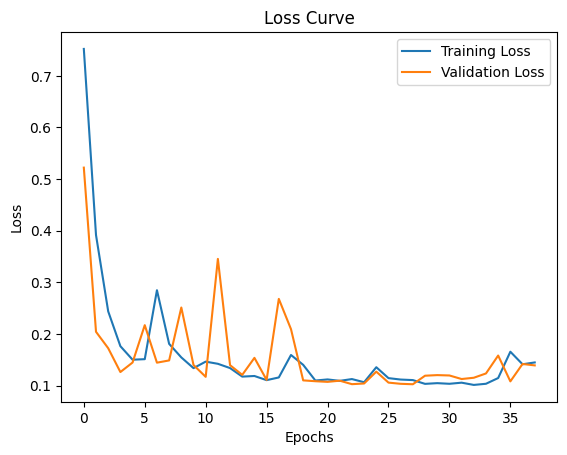

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test, y_test_onehot, verbose=1)
print(f"Test Accuracy: {test_accuracy:.2f}")

y_pred = np.argmax(model.predict(x_test), axis=1)
y_true = np.argmax(y_test_onehot, axis=1)

93/93 [==============================] - 4s 38ms/step - loss: 0.2325 - accuracy: 0.9023
Test Accuracy: 0.90


2024-11-24 15:51:36.508004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-24 15:51:36.615232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 5/93 [>.............................] - ETA: 1s  

2024-11-24 15:51:36.746115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - 2s 12ms/step



Classification Report:
                    precision    recall  f1-score   support

           WALKING       0.98      0.92      0.94       496
  WALKING_UPSTAIRS       0.91      0.98      0.94       471
WALKING_DOWNSTAIRS       0.99      1.00      0.99       420
           SITTING       0.83      0.67      0.74       491
          STANDING       0.75      0.86      0.80       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.90      2947
         macro avg       0.91      0.90      0.90      2947
      weighted avg       0.90      0.90      0.90      2947


Confusion Matrix:


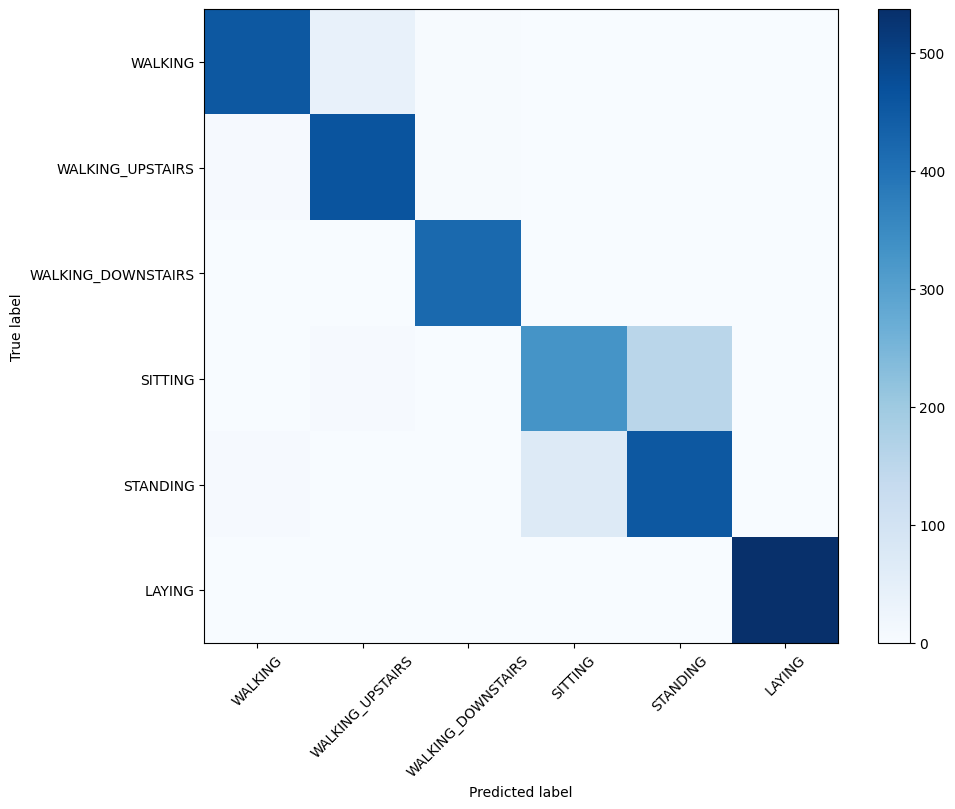

In [ ]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()